This SageMath notebook is intended to take a DT sequence for a knotted 4-valent graph, and produce the associated graph polynomial. This is done in a few steps:

1. Find the orientation of the graph nodes by running the DT algorithm on the sequence, giving the $f(i)$ function on node labels i. The convention is that $f(i) = +1$ if the other arc crosses from right to left, and $f(i) = -1$ if the other arc crosses from left to right.
1. Once the orientation is known, it is possible to use the graph polynomial skein relation to find the polynomial in terms of sums of polynomials in the variables $a, b, c, d$, each multiplied by a link.

Define the DT sequence for the graph. Remember that this should be a Python list of three element lists. The first element is an even number, the second an odd; these are the two labels for that particular node. The third element gives the crossing or vertex type: -2 for a vertex with the upper edge on the odd label (label superscript $\ell$), -1 for a crossing with the upper edge on the odd label (label superscript $-$), and the positive numbers are the flipped cases (superscripts $u$ and $+$).

The test case is for the graph sequence $3^\ell 5^\ell 7^\ell 1^\ell$, which corresponds to the Python list

```python
    seq = [[0, 3, -2], [2, 5, -2], [4, 7, -2], [6, 1, -2]]
```

In [48]:
seq = [[0, 3, -2], [2, 5, -2], [4, 7, -2], [6, 1, -2]]

Define the graph polynomial variables.

In [49]:
var('a b c d')

(a, b, c, d)

The following imports the function `isRealizable()` for the DT sequence `seq`, which gives the sequence orientation information $f(i)$. For a list `seq` corresponding to a realizable DT sequence, calling `isRealizable(seq, f_list = True)` will give a list of $f(i)$ values for each node label $i$. **Note:** Evidently, Jupyter notebooks require a beginning capital letter for the name of the folder from which the module is imported.

In [50]:
from Graphmaker.isRealizable import isRealizable

The next command creates the orientation list `orientList` for the DT sequence `seq`.

In [51]:
orientList = isRealizable(seq, f_list = True)
orientList

[1, 1, -1, -1, 1, 1, -1, -1]

The next function takes the DT sequence and orientation lists, and produces a planar diagram list from them. This will be used in the actual algorithm to find the graph polynomial.

In [52]:
def planarDiagram(seq, f_list):
    """
    Given DT sequence and orientation lists for a graph,
    return the planar diagram list for that sequence.
    """
    
    # Find number of nodes
    
    num_node = len(seq)
    
    # Create PD list and node type lists to return
    
    pd_list = [[] for iii in range(num_node)]
    type_list = [0 for iii in range(num_node)]
    
    # Go through the DT sequence, and find the PD sequence;
    # at first, we tack the type list onto the end of the PD
    # sequence, so we can sort the sequence, then strip off
    # the type information at the end
    #
    # We also need to include additional information for the
    # vertices so that the delta move can be performed.
    # Specifically, when the vertex with labels [a0, a1, a2, a3]
    # has the delta move acting on it, the result can be:
    #
    #    1. [a1, a2, a3, a0] when the even label i has
    #    f(i) = +1 and is a lower edge on the vertex, or
    #    the even label has f(i) = -1 and is an upper edge
    #
    #    2. [a3, a0, a1, a2] when the even label i has
    #    f(i) = +1 and is an upper edge on the vertex, or
    #    the even label has f(i) = -1 and is a lower edge
    #
    # For the first case, we give the (possibly new) node
    # label as +2, and the second, -2.
    
    for jjj in range(num_node):
        node = seq[jjj]
        
        # If node[2] is negative, this means the even label is
        # the undercrossing or the lower edge, if a vertex
        
        if node[2] < 0:
            
            # Lower edge, f(i) = +1
            
            if f_list[node[0]] == 1:
                pd_list[jjj] = [node[0], node[1], (node[0] + 1) % (2 * num_node),
                                (node[1] + 1) % (2 * num_node), -node[2]]
                
            # Lower edge, f(i) = -1
                
            elif f_list[node[0]] == -1:
                pd_list[jjj] = [node[0], (node[1] + 1) % (2 * num_node),
                                (node[0] + 1) % (2 * num_node), node[1], node[2]]
        
        # If node[2] is positive, this means the even label is
        # the overcrossing or the upper edge, if a vertex
        
        elif node[2] > 0:
            
            # Upper edge, f(i) = +1
            
            if f_list[node[0]] == 1:
                pd_list[jjj] = [node[1], (node[0] + 1) % (2 * num_node),
                                (node[1] + 1) % (2 * num_node), node[0], -node[2]]
                
            # Upper edge, f(i) = -1
            
            elif f_list[node[0]] == -1:
                pd_list[jjj] = [node[1], node[0], (node[1] + 1) % (2 * num_node),
                                (node[0] + 1) % (2 * num_node), node[2]]
                
    # Sort resulting PD list, then strip off
    # type information for separate list; since
    # SageMath wants the edge labels to start
    # with 1 vice 0, we add one here, to get
    # the range (1, ..., num_node) instead of
    # (0, ..., num_node - 1)
    
    pd_list.sort()
    
    type_list = [node[4] for node in pd_list]
    pd_list = [[node[0] + 1, node[1] + 1, node[2] + 1, node[3] + 1] for node in pd_list]
    
    # Return results
                
    return [pd_list, type_list]

In [57]:
planarDiagram(seq, orientList)

[[[1, 4, 2, 5], [3, 7, 4, 6], [5, 8, 6, 1], [7, 3, 8, 2]], [2, -2, 2, -2]]

Before we get into solving for the graph polynomials, we need one additional function. Since SageMath evidentally does not like it when a link given in PD notation has two edges on the same crossing, we create a function to check if this is true. Only adjacent edges could be the problem -- otherwise, they would cross over or under another edge, and have different labels.

In [1]:
def doubleEdge(label_list):
    """
    Given a list of four edge labels, see if any
    two of them are the same. Reports which labels
    are common if so, and False otherwise.
    """
    
    for iii in range(4):
        if label_list[iii - 1] == label_list[iii]:
            return sorted[(iii - 1) % 4, iii]
        
    return False

In [129]:
def graphPoly(pd_list, type_list):
    """
    This is a recursive function to find the graph
    polynomial associated with the graph described
    by the PD list pd_list and the orientation list
    type_list. When the algorithm is complete, it
    will return the graph polynomial.
    """
    
    print(pd_list, type_list)
    
    # If the graph has been completely reduced down
    # to a link, return the link invariant polynomial,
    # using any choice of such invariant
    
    if type_list == []:
        L = Link(pd_list)
        print(L.jones_polynomial(skein_normalization = True))
        return L.jones_polynomial(skein_normalization = True)
    
    # If the graph has not been completely reduced,
    # work on last node; this will be deleted from the
    # end of type_list, but kept in pd_list, so the
    # link invariant can be calculated.
    
    # If the node type is a crossing, return the function
    # for the remainder of the graph, without the given
    # crossing
    
    if abs(type_list[-1]) == 1:
        return graphPoly(pd_list, type_list[:-1])
    
    # If the node type is a vertex, use the graph
    # polynomial skein relation.
    
    elif abs(type_list[-1]) == 2:
    
        # Create new function to return

        new_func = 0
        
        # Which node are we working with? Given by length of
        # current type_list
        
        node_index = len(type_list) - 1
    
        #--------------------------------------------------------------------#
        
        # Case Alpha -- vertex is removed, edges are connected
        #   so that incoming edge "goes to the left" through
        #   the vertex
        
        # For a node with edge labels in the form [a0, a1, a2, a3]
        # replace max(a0, a1) with min(a0, a1), and replace
        # max(a2, a3) with min(a2, a3)
        
        first_max = max(pd_list[node_index][0], pd_list[node_index][1])
        first_min = min(pd_list[node_index][0], pd_list[node_index][1])
        
        second_max = max(pd_list[node_index][2], pd_list[node_index][3])
        second_min = min(pd_list[node_index][2], pd_list[node_index][3])
        
        new_pd_list = pd_list[:]
        
        # It is possible for a alpha move to create a new unknot
        # if a0 = a1 or a2 = a3, so account for that possibility;
        # if a0 = a1 *and* a2 = a3, then two unknots are created
        
        if first_min == first_max and second_min == second_max:
            
            # Find largest current edge label, delete current
            # node, and add two new unknots to end, using edge
            # labels higher than any currently in PD form; do it
            # in this order, just in case current node is last one
            
            max_label = max([max(node) for node in new_pd_list])
            del new_pd_list[node_index]
            new_pd_list += [[max_label + 1, max_label + 1, max_label + 2, max_label + 2],
                           [max_label + 3, max_label + 3, max_label + 4, max_label + 4]]
            
        elif not (first_min == first_max or second_min == second_max):
            del new_pd_list[node_index]
            
        # Go through and remove max edge labels, replace with mins
        
        for node in new_pd_list:
            for iii in range(4):
                if node[iii] == first_max:
                    node[iii] = first_min
                elif node[iii] == second_max:
                    node[iii] = second_min
        
        new_func += a * graphPoly(new_pd_list, type_list[:-1])
    
        #--------------------------------------------------------------------#

        # Case Bravo -- vertex is removed, edges are connected
        #   so that incoming edge "goes to the right" through
        #   the vertex
        
        # For a node with edge labels in the form [a0, a1, a2, a3]
        # replace max(a0, a3) with min(a0, a3), and replace
        # max(a1, a2) with min(a1, a2)
        
        first_max = max(pd_list[node_index][0], pd_list[node_index][3])
        first_min = min(pd_list[node_index][0], pd_list[node_index][3])
        
        second_max = max(pd_list[node_index][1], pd_list[node_index][2])
        second_min = min(pd_list[node_index][1], pd_list[node_index][2])
        
        new_pd_list = pd_list[:]
        
        # It is possible for a beta move to create a new unknot
        # if a0 = a3 or a1 = a2, so account for that possibility
        
        if not (first_min == first_max or second_min == second_max):
            del new_pd_list[node_index]
            
        # Go through and remove max edge labels, replace with mins
        
        for node in new_pd_list:
            for iii in range(4):
                if node[iii] == first_max:
                    node[iii] = first_min
                elif node[iii] == second_max:
                    node[iii] = second_min
        
        new_func += b * graphPoly(new_pd_list, type_list[:-1])
    
        #--------------------------------------------------------------------#
    
        # Case Gamma -- vertex is removed and replaced by
        #   crossing, with upper edge of vertex becoming
        #   upper edge of crossing
        
        # In this case, the upper edge just becomes an
        # upper crossing.
        
        new_func += c * graphPoly(pd_list[:], type_list[:-1])
    
        #--------------------------------------------------------------------#

        # Case Delta -- vertex is removed and replaced by
        #   crossing, with upper edge of vertex becoming
        #   lower edge of crossing

        # Use positive/negative information given in vertex
        # type to change labels for this vertex
        
        new_pd_list = pd_list[:]
        change = type_list[node_index] / abs(type_list[node_index])
        new_pd_list[node_index] = [new_pd_list[node_index][(iii + change) % 4] for iii in range(4)]
        
        new_func += d * graphPoly(new_pd_list, type_list[:-1])
    
        #--------------------------------------------------------------------#
        
        # Return resulting polynomial
        
        return new_func

In [130]:
seq = [[0, 3, 2], [2, 5, 2], [4, 1, 2]]
orientList = isRealizable(seq, f_list = True)
function = graphPoly(*planarDiagram(seq, orientList))
function

([[2, 6, 3, 5], [4, 2, 5, 1], [6, 4, 1, 3]], [-2, -2, -2])
([[2, 4, 1, 5], [4, 2, 5, 1]], [-2, -2])
([[2, 2, 1, 1]], [-2])
([[3, 3, 4, 4], [5, 5, 6, 6]], [])
-A^-2 - A^2
([], [])
-A^-2 - A^2
([[2, 2, 1, 1]], [])
1
([[1, 2, 2, 1]], [])
1
([[2, 2, 1, 1]], [-2])
([[3, 3, 4, 4], [5, 5, 6, 6]], [])
-A^-2 - A^2
([], [])
-A^-2 - A^2
([[2, 2, 1, 1]], [])
1
([[1, 2, 2, 1]], [])
1
([[2, 2, 1, 1], [4, 2, 5, 1]], [-2])
([[4, 2, 5, 1], [6, 6, 7, 7], [8, 8, 9, 9]], [])


ValueError: invalid PD code: each segment must appear twice

In [131]:
L = Link([[4, 2, 5, 1], [6, 6, 7, 7], [8, 8, 9, 9]])

ValueError: invalid PD code: each segment must appear twice

In [96]:
L.jones_polynomial(skein_normalization = True)

-A^-2 - A^2

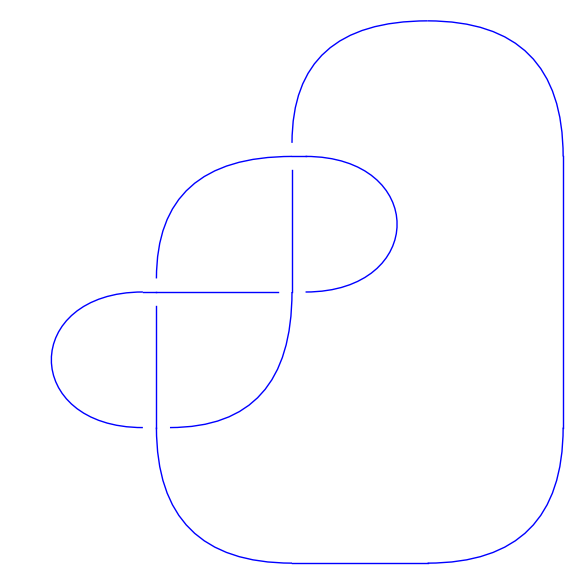

In [18]:
M = Link([[1, 4, 2, 5], [3, 7, 4, 6], [5, 8, 6, 1], [7, 3, 8, 2]])
M.jones_polynomial()
M.plot()

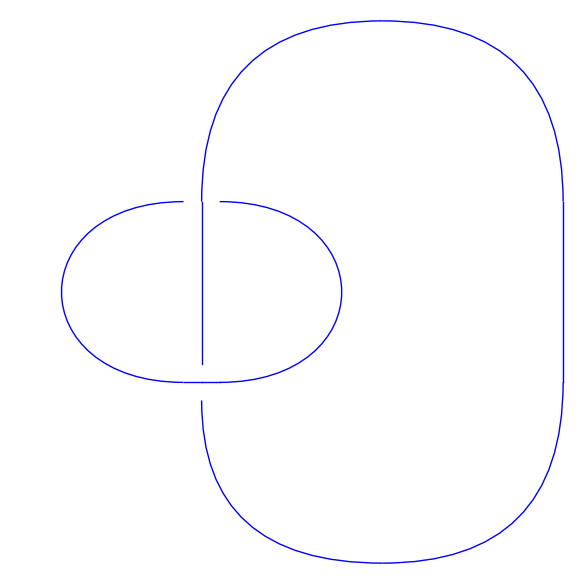

In [19]:
L = Link([[1, 4, 2, 3], [4, 1, 3, 2]])
L.plot()

In [56]:
graphPoly([[1, 5, 2, 4], [5, 3, 6, 2], [3, 1, 4, 6]], [1, 1, 1])

1/t + 1/t^3 - 1/t^4

In [89]:
graphList = [[0, 3, -1], [2, 5, -1], [4, 1, -1]]
fList = isRealizable(graphList, f_list = True)
print(fList)
graphPoly(*planarDiagram(graphList, fList))

[1, -1, 1, -1, 1, -1]


-t^4 + t^3 + t

In [91]:
graphList = [[0, 3, 1], [2, 5, 1], [4, 1, 1]]
fList = isRealizable(graphList, f_list = True)
print(fList)
graphPoly(*planarDiagram(graphList, [-f for f in fList]))

[1, -1, 1, -1, 1, -1]


-t^4 + t^3 + t

In [76]:
A = [1, 2, 3, 4]
A.remove(0)

ValueError: list.remove(x): x not in list

In [3]:
A[:2] + A[3:]

[1, 2, 4]

In [10]:
K = []
H = [[1, 5, 2, 4], [5, 3, 6, 2], [3, 1, 4, 6]]
for node in H:
    for iii in range(4):
        if node[iii] == 1:
            node[iii] = 0
        elif node[iii] == 6:
            node[iii] = 7
    
print(H)

[[0, 5, 2, 4], [5, 3, 7, 2], [3, 0, 4, 7]]


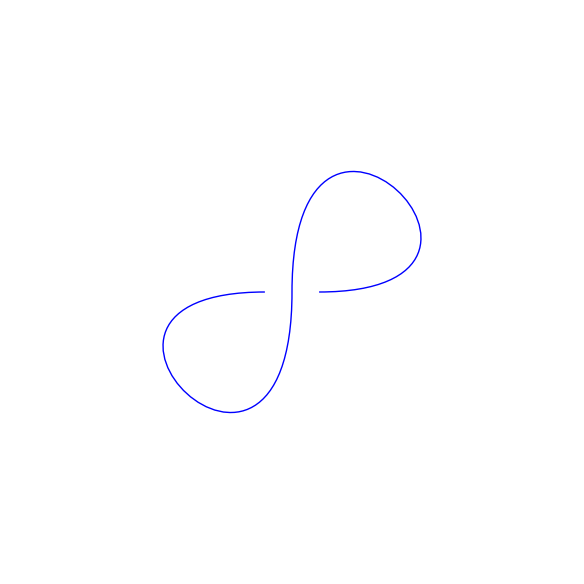

In [18]:
L = Link([[2, 1, 1, 2]])
L.plot()

In [27]:
L.jones_polynomial(skein_normalization = True)

1

In [34]:
K = Link([[2, 2, 3, 1], [3, 4, 4, 1]])

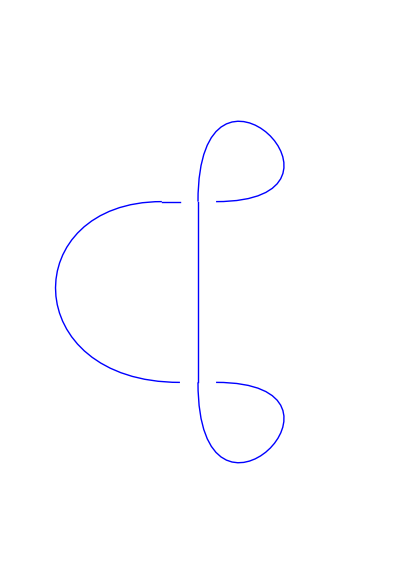

In [35]:
K.plot()

In [37]:
L = K.oriented_gauss_code()

In [95]:
max([[2, 6, 3, 5], [4, 2, 5, 1], [6, 4, 1, 3]])

[6, 4, 1, 3]

In [45]:
A = [0, 1, 2, 3]
print([A[(iii + 1) % 4] for iii in range(4)])
print([A[(iii - 1) % 4] for iii in range(4)])

[1, 2, 3, 0]
[3, 0, 1, 2]
